In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

Data Cleaning

In [2]:
# read in the stock data and engineer the label column by
# looking at change in stock price between now and future date

with open('data/stock-data.json') as in_file:
    stock_data = json.load(in_file)
snp_df = pd.DataFrame(stock_data['Time Series (Daily)']).T
snp_df = snp_df.rename(columns={'4. close': 'close'})[['close']].sort_index()
snp_df['close'] = snp_df['close'].astype(float)
snp_df = snp_df.reset_index().rename(columns={'index':'Date'})
snp_df['Date'] = snp_df['Date'].str.replace('-', '/')
snp_df['future_close'] = snp_df['close'].shift(-12)
snp_df = snp_df.dropna(subset=['future_close'])
snp_df['price_move'] = (snp_df['future_close'] - snp_df['close']) / snp_df['close'] * 100
snp_df['price_increased'] = snp_df['price_move'] > 0
snp_df

,Date,close,future_close,price_move,price_increased
0,1999/11/01,135.5625,141.6250,4.472107,True
1,1999/11/02,134.5937,142.6250,5.967070,True
2,1999/11/03,135.5000,142.5000,5.166052,True
3,1999/11/04,136.5312,142.4687,4.348823,True
4,1999/11/05,137.8750,141.2187,2.425168,True
...,...,...,...,...,...
6070,2023/12/15,469.3300,467.2800,-0.436793,False
6071,2023/12/18,471.9700,467.9200,-0.858105,False
6072,2023/12/19,474.8400,474.6000,-0.050543,False
6073,2023/12/20,468.2600,473.8800,1.200188,True


In [3]:
# read in headlines data and remove punctuation

news_df = pd.read_csv('data/headlines.csv')
news_df = news_df.merge(snp_df, how='left', on='Date')
news_df = news_df.dropna(subset=['price_increased', 'Headline'])
news_df['Headline'].replace("[^a-zA-Z ]+"," ",regex=True, inplace=True)
news_df = news_df.reset_index().sort_values('Date')
news_df

,index,Date,Headline,close,future_close,price_move,price_increased
0,34,2001/01/02,The Right Recipe for Republicans,128.8125,134.0156,4.039282,True
32,66,2001/01/02,Intershop Profit Warning Hits Market,128.8125,134.0156,4.039282,True
33,67,2001/01/02,CAC Falls as Telecoms Slide,128.8125,134.0156,4.039282,True
34,68,2001/01/02,Muscadet With Shrimp,128.8125,134.0156,4.039282,True
35,69,2001/01/02,Allergic to Most Wine,128.8125,134.0156,4.039282,True
...,...,...,...,...,...,...,...
346609,461156,2023/12/21,Peyton s Places The Santa Game Philadelphia...,472.7000,476.5600,0.816586,True
346610,461157,2023/12/21,All of Us Strangers Review A Ghostly Drama ...,472.7000,476.5600,0.816586,True
346611,461158,2023/12/21,The Color Purple Bright Movie Big Emotions,472.7000,476.5600,0.816586,True
346613,461160,2023/12/21,Ultragenyx to Pay Million to Settle Alleged ...,472.7000,476.5600,0.816586,True


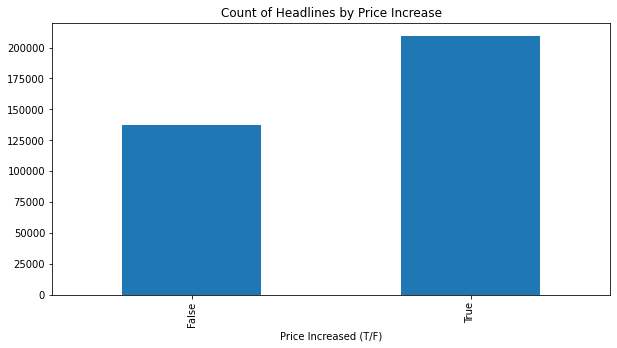

In [4]:
ax = news_df['price_increased'].value_counts().sort_index().plot(kind='bar', title='Count of Headlines by Price Increase', figsize=(10, 5))
ax.set_xlabel('Price Increased (T/F)')
plt.show()

Sentiment Intensity Analysis

In [29]:
# import pre-trained sentiment analysis model

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jeffrey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# get sentiment scores for each headline

sia = SentimentIntensityAnalyzer()

results = {}

for i, row in news_df.iterrows():
    headline = row['Headline']
    id = row['index']
    results[id] = sia.polarity_scores(headline)

In [9]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index()
vaders = vaders.merge(news_df, how='left', on='index')

In [10]:
vaders.head()

,index,neg,neu,pos,compound,Date,Headline,close,future_close,price_move,price_increased
0,34,0.000,1.000,0.000,0.000,2001/01/02,The Right Recipe for Republicans,128.8125,134.0156,4.039282,True
1,66,0.289,0.361,0.349,0.128,2001/01/02,Intershop Profit Warning Hits Market,128.8125,134.0156,4.039282,True
2,67,0.000,1.000,0.000,0.000,2001/01/02,CAC Falls as Telecoms Slide,128.8125,134.0156,4.039282,True
3,68,0.000,1.000,0.000,0.000,2001/01/02,Muscadet With Shrimp,128.8125,134.0156,4.039282,True
4,69,0.423,0.577,0.000,-0.296,2001/01/02,Allergic to Most Wine,128.8125,134.0156,4.039282,True


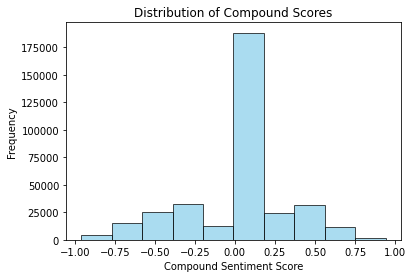

In [11]:
plt.hist(vaders['compound'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Scores')
plt.show()

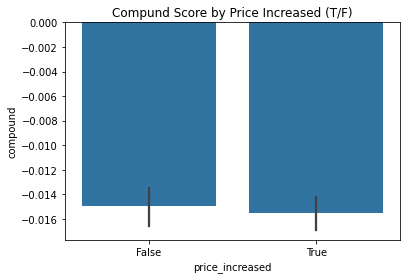

In [12]:
ax = sns.barplot(data=vaders, x='price_increased', y='compound')
ax.set_title('Compund Score by Price Increased (T/F)')
plt.show()

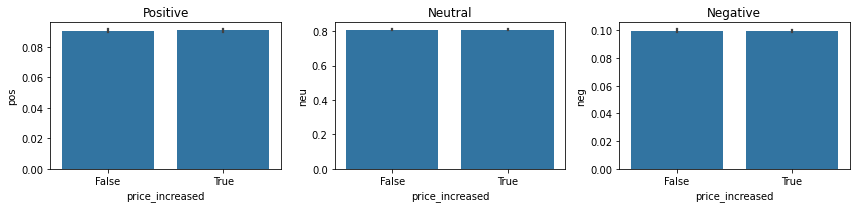

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='price_increased', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='price_increased', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='price_increased', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

Basic Logistic Regression Classification Using Sentiment Features

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [49]:
# group by date and then take the average of each
# negative, neutral, and positive sentiment intensity score
avg_sentiment_df = vaders.groupby('Date').agg({'neg': 'mean', 'neu': 'mean', 'pos': 'mean', 'price_increased': lambda x: all(x)})


In [50]:
sentiment_X = avg_sentiment_df[['neg', 'neu', 'pos']]
sentiment_y = avg_sentiment_df['price_increased']
sentiment_X_train, sentiment_X_test, sentiment_y_train, sentiment_y_test = train_test_split(sentiment_X, sentiment_y, test_size=0.2, random_state=12)

In [51]:
# Initialize and train the Logistic Regression model
sentiment_model = LogisticRegression()
sentiment_model.fit(sentiment_X_train, sentiment_y_train)

LogisticRegression()

In [52]:
# Make predictions on the test set
sentiment_y_pred = sentiment_model.predict(sentiment_X_test)

# Evaluate the model
accuracy = accuracy_score(sentiment_y_test, sentiment_y_pred)
classification_rep = classification_report(sentiment_y_test, sentiment_y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_rep)

Accuracy: 0.5960
Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       467
        True       0.60      1.00      0.75       689

    accuracy                           0.60      1156
   macro avg       0.30      0.50      0.37      1156
weighted avg       0.36      0.60      0.45      1156



c:\Users\Jeffrey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jeffrey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Jeffrey\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

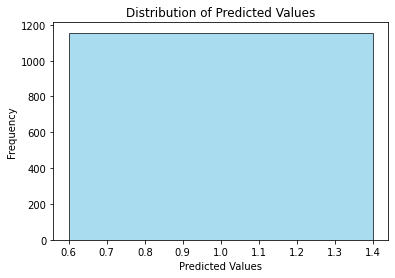

In [53]:
unique_values, counts = np.unique(sentiment_y_pred, return_counts=True)

# Create a bar chart
plt.bar(unique_values, counts, color=['skyblue', 'orange'], edgecolor='black', alpha=0.7)

# Customize the plot
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [61]:
print("Number of False predictions: " + str(np.sum(sentiment_y_pred == False)))

Number of False predictions: 0


Word2Vec with Long Short-Term Memory Neural Network Classification

In [54]:
agg_funcs = {
    'Headline': lambda x: ' '.join(x),
    'price_increased': lambda x: all(x)
}
agg_news_df = news_df.groupby('Date').agg(agg_funcs).reset_index()
agg_news_df

,Date,Headline,price_increased
0,2001/01/02,The Right Recipe for Republicans Intershop Pro...,True
1,2001/01/03,Schrempp Plans U S Controlled Chrysler Techs ...,False
2,2001/01/04,Letsbuyit s Management Board Resigns Telecoms ...,True
3,2001/01/05,A Week of Diversions January January Sha...,True
4,2001/01/08,CAC Slips Amid Acquisitions Banking Sector Buo...,True
...,...,...,...
5775,2023/12/15,Hawaiian Lawmakers Want Overhaul in Fire Preve...,False
5776,2023/12/18,Vatican Issues Guidelines for Same Sex Blessin...,False
5777,2023/12/19,Fatherlessness Crime and Striving to Succeed ...,False
5778,2023/12/20,Hamas Rejection Sours Israeli Bid to Revive Ho...,True


In [55]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec

In [63]:
# Preprocess the data
encoder = LabelEncoder()
agg_news_df['price_increased'] = encoder.fit_transform(agg_news_df['price_increased'])

# Train Word2Vec model
sentences = [headline.split() for headline in agg_news_df['Headline']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=3)

# Tokenize and pad the headlines using Word2Vec embeddings
max_words = len(word2vec_model.wv)
embedding_matrix = np.zeros((max_words, word2vec_model.vector_size))
for word, i in word2vec_model.wv.key_to_index.items():
    if i < max_words:
        embedding_matrix[i] = word2vec_model.wv[word]

word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
sequences = [[word_index[word] for word in headline.split() if word in word_index] for headline in agg_news_df['Headline']]

# Pad sequences
padded_sequences = np.array([np.pad(seq, (0, max(0, 10 - len(seq))), 'constant')[:10] for seq in sequences])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, agg_news_df['price_increased'], test_size=0.2, random_state=48)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=word2vec_model.vector_size, weights=[embedding_matrix], input_length=10, trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [64]:
# compile the model and specify optimizer, loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
# train model
model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3


145/145 [==============================] - 3s 8ms/step - loss: 0.6778 - accuracy: 0.5960 - val_loss: 0.6737 - val_accuracy: 0.6073
Epoch 2/3
145/145 [==============================] - 1s 6ms/step - loss: 0.6570 - accuracy: 0.6155 - val_loss: 0.6793 - val_accuracy: 0.5856
Epoch 3/3
145/145 [==============================] - 1s 6ms/step - loss: 0.6444 - accuracy: 0.6272 - val_loss: 0.6798 - val_accuracy: 0.5934


In [66]:
# evaluate effectiveness of model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

 1/37 [..............................] - ETA: 0s - loss: 0.6606 - accuracy: 0.5625

37/37 [==============================] - 0s 3ms/step - loss: 0.6798 - accuracy: 0.5934
Test Loss: 0.6798, Test Accuracy: 0.5934


In [67]:
y_pred = model.predict(X_test)
print("Number of False predictions: " + str(np.sum(y_pred == False)))

37/37 [==============================] - 1s 3ms/step
Number of False predictions: 0
